## Dollar Cost Averaging (DCA) vs Value Averaging (VA) Investing

The idea behind this analysis is to compare the results together with strengths and weaknesses of two popular investing methods - Dollar Cost Averaging and Value Averaging. To do that I will use simple yet powerful set of analytical tools - Python programming language with Pandas module to manipulate the data and Matplotlib module to visualize it. 

Before I start let me first briefly explain both of the concepts by quoting investopedia and displaying table examples:

**[Dollar Costs Averaging](https://www.investopedia.com/terms/d/dollarcostaveraging.asp)** - 
 "is an investment technique of buying a fixed dollar amount of a particular investment on a regular schedule, regardless of the share price. The investor purchases more shares when prices are low and fewer shares when prices are high."
 
 An example of **3 period DCA with contribution of \$1000 per period:**
 ![title](DCA_table.jpg)
 
 **[Value Averaging](https://www.investopedia.com/terms/v/value_averaging.asp)** - 
 "An investing strategy that works like dollar cost averaging (DCA) in terms of steady monthly contributions, but differs in its approach to the amount of each monthly contribution. In value averaging, the investor sets a target growth rate or amount on his or her asset base or portfolio each month, and then adjusts the next month's contribution according to the relative gain or shortfall made on the original asset base."
 
  An example of **3 period VA with incremental target value of \$1000 per period:**
 ![title](VA_table.jpg)
 

### Analysis Assumptions:
* 6 years or 24 quarters worth of data
* 3 case studies (uptrend, downtrend and horizontal) to examine results in each of the market conditions
* Investment starts on last day of 1Q 2012 with \$10,000 initial contribution 
* Following the initial investment contributions of \$2,500 are made quarterly on last quarter day for DCA and similarly target value increase by $2,500 quarterly for VA
* To keep it simple transaction fees and commissions are ignored

In [34]:
initial_inv = -10000
quarterly_contribution = -2500
start = '20120101'
end = '20180102'

### Xirr to find outperforming strategy:
XIRR is a function for calculatation of internal rate of return (annualized return) for cash flows occurring at irregular intervals. Xirr is commonly used in spreadsheets to analyse investment performance across times series. Sadly no major python data analysis module (numpy, pandas etc.) has xirr function  included. However github user **peliot created module with python implementations of Microsoft Excel's XNPV and XIRR functions**. You can find it [here](https://github.com/peliot/XIRR-and-XNPV) and while visiting peliot's git don't forget to give him a well deserved star!


 In this study negative cash flows (investments) are occuring on a quarterly basis while positive cash flow (divestment) occurs on the last day of 4Q 2017.

### Importing modules and setting visualisation options:

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import financial
from matplotlib import style
pd.set_option('display.float_format', lambda x: '%.2f' % x)
style.use('ggplot')
% matplotlib inline

# Study 1: Uptrend

As an example of bull market I will use the most obvious one - the **S&P 500** index which in the last six years saw spectacular performance - achieving **six year return of ~109%**.

### Stock performance visualisation 

In [36]:
def quotes_df(ticker, start, end):
    '''
    Downloads quotes in csv and loads into pandas DataFrame
    ticker - 'APPL'
    start - 'YYYYMMDD'
    end - 'YYYYMMDD"
    '''
    url = "".join(("https://stooq.pl/q/d/l/?s=", ticker, "&d1=", start, "&d2=", end, "&i=d"))
    df = pd.read_csv(url)
    df = df[['Data','Zamkniecie']]
    df['Data'] = pd.to_datetime(df["Data"], format='%Y-%m-%d')
    df.set_index('Data', inplace=True)
    df.rename(columns={'Zamkniecie':'Price'}, inplace=True)
    return df

In [37]:
bull_df = quotes_df('^SPX', start, end)

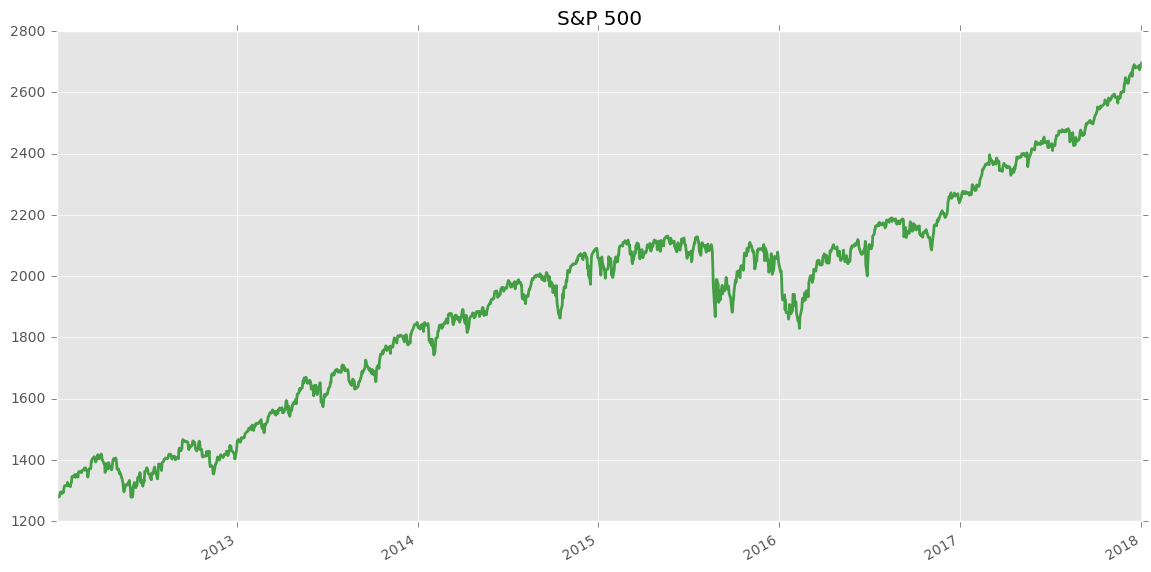

In [38]:
ax = bull_df.plot(figsize=(14,7), linewidth=2, legend=False, title = 'S&P 500', color='g', alpha=0.7)
plt.xlabel('');

### Dollar Cost Averaging DataFrame:

In [39]:
def dca_df_creator(df, **quess_val):
    dca_df = df.asfreq(freq='Q',method='ffill')
    dca_df['DCA_contr'] = initial_inv
    dca_df.iloc[1:,1] = quarterly_contribution
    dca_df['DCA_cum_inv'] = dca_df['DCA_contr'].cumsum()
    dca_df['DCA_shares_bought'] = -dca_df['DCA_contr']/dca_df.iloc[:,0]
    dca_df['DCA_cum_shares'] = dca_df['DCA_shares_bought'].cumsum()
    dca_df['DCA_Total_Val'] = dca_df['DCA_cum_shares'] * dca_df.iloc[:,0]
    dca_df['DCA_avg_price'] = -dca_df['DCA_cum_inv'] / dca_df['DCA_cum_shares']
    dca_df['DCA_P&L'] = dca_df['DCA_Total_Val'] + dca_df['DCA_cum_inv']
    values = list(dca_df['DCA_contr'])
    values.append(dca_df['DCA_Total_Val'][-1])
    dates = list(dca_df.index)
    dates.append(dca_df.index[-1])
    feed = []
    for date, val in zip(dates, values):
        feed.append((date, val))
    dca_xirr = financial.xirr(tuple(feed), guess=quess_val.get('guess_val',0.1))
    return dca_df, dca_xirr

In [40]:
bull_dca, bull_dca_xirr = dca_df_creator(bull_df)
bull_dca

,Price,DCA_contr,DCA_cum_inv,DCA_shares_bought,DCA_cum_shares,DCA_Total_Val,DCA_avg_price,DCA_P&L
Data,,,,,,,,
2012-03-31,1408.47,-10000,-10000,7.10,7.10,10000.00,1408.47,0.00
2012-06-30,1362.16,-2500,-12500,1.84,8.94,12171.20,1398.96,-328.80
2012-09-30,1440.67,-2500,-15000,1.74,10.67,15372.71,1405.74,372.71
2012-12-31,1426.19,-2500,-17500,1.75,12.42,17718.20,1408.63,218.20
2013-03-31,1569.19,-2500,-20000,1.59,14.02,21994.75,1426.88,1994.75
2013-06-30,1606.28,-2500,-22500,1.56,15.57,25014.63,1444.81,2514.63
2013-09-30,1681.55,-2500,-25000,1.49,17.06,28686.81,1465.44,3686.81
2013-12-31,1848.36,-2500,-27500,1.35,18.41,34032.55,1493.57,6532.55
2014-03-31,1872.34,-2500,-30000,1.34,19.75,36974.07,1519.18,6974.07


### Value Averaging DataFrame

In [41]:
def va_df_creator(df, **quess_val):   
    va_df = df.asfreq(freq='Q',method='ffill')
    va_df['VA_target'] = initial_inv
    va_df.iloc[1:,1] = quarterly_contribution
    va_df['VA_target_cum'] = va_df['VA_target'].cumsum()
    va_df['VA_target_shares'] = -va_df['VA_target']/va_df.iloc[:,0]
    va_df.loc[va_df.index[0],'VA_contr'] = initial_inv
    va_df.loc[va_df.index[0],'VA_shares_bought'] = -initial_inv/va_df.iloc[:,0][0]
    va_df.loc[va_df.index[0],'VA_cum_shares'] = va_df['VA_shares_bought'][0]
    n = 0
    for i, row in va_df.iterrows():
        cur_target = va_df['VA_target_cum'][i]
        prev_cum = va_df['VA_cum_shares'][n-1]
        cur_price = va_df.iloc[:,0][i]
        n += 1
        if i == va_df.index[0]:
            continue
        else:
            cur_cont = cur_target + (prev_cum * cur_price)
            cur_shares = -cur_cont / cur_price
            va_df.loc[i,'VA_contr'] = cur_cont
            va_df.loc[i, 'VA_shares_bought'] = cur_shares
            va_df.loc[i, 'VA_cum_shares'] = prev_cum + cur_shares
    va_df['VA_cum_inv'] = va_df['VA_contr'].cumsum()
    va_df['VA_Total_Val'] = va_df['VA_cum_shares'] * va_df.iloc[:,0]
    va_df['VA_avg_price'] = -va_df['VA_cum_inv'] / va_df['VA_cum_shares']
    va_df['VA_P&L'] = va_df['VA_Total_Val'] + va_df['VA_cum_inv']
    values = list(va_df['VA_contr'])
    values.append(va_df['VA_Total_Val'][-1])
    dates = list(va_df.index)
    dates.append(va_df.index[-1])
    feed = []
    for date, val in zip(dates, values):
        feed.append((date, val))
    va_xirr = financial.xirr(tuple(feed), guess=quess_val.get('guess_val',0.1))
    va_df = va_df[['Price', 'VA_contr', 'VA_cum_inv', 'VA_shares_bought','VA_cum_shares',
                   'VA_Total_Val', 'VA_avg_price', 'VA_P&L']]
    return va_df, va_xirr

In [42]:
bull_va, bull_va_xirr = va_df_creator(bull_df)
bull_va

,Price,VA_contr,VA_cum_inv,VA_shares_bought,VA_cum_shares,VA_Total_Val,VA_avg_price,VA_P&L
Data,,,,,,,,
2012-03-31,1408.47,-10000.00,-10000.00,7.10,7.10,10000.00,1408.47,0.00
2012-06-30,1362.16,-2828.80,-12828.80,2.08,9.18,12500.00,1397.99,-328.80
2012-09-30,1440.67,-1779.54,-14608.34,1.24,10.41,15000.00,1403.05,391.66
2012-12-31,1426.19,-2650.76,-17259.10,1.86,12.27,17500.00,1406.56,240.90
2013-03-31,1569.19,-745.32,-18004.43,0.47,12.75,20000.00,1412.62,1995.57
2013-06-30,1606.28,-2027.27,-20031.70,1.26,14.01,22500.00,1430.07,2468.30
2013-09-30,1681.55,-1445.65,-21477.36,0.86,14.87,25000.00,1444.61,3522.64
2013-12-31,1848.36,-20.00,-21497.35,0.01,14.88,27500.00,1444.90,6002.65
2014-03-31,1872.34,-2143.22,-23640.58,1.14,16.02,30000.00,1475.44,6359.42


### Bull market results comparison

In [43]:
def comparison_graphs(df_dca, df_va):
    return_df = pd.concat([df_dca[['DCA_cum_inv','DCA_P&L']], df_va[['VA_cum_inv','VA_P&L']]], axis=1)
    return_df['DCA_return'] = return_df['DCA_P&L'] / -return_df['DCA_cum_inv']*100
    return_df['VA_return'] = return_df['VA_P&L'] / -return_df['VA_cum_inv']*100
    return_df['diff'] = return_df['VA_return'] - return_df['DCA_return']

    fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(15,10))
    ax1.plot(return_df.index, return_df['VA_return'], linewidth=3, label='Value Averaging', color='b')
    ax1.plot(return_df.index, return_df['DCA_return'], linewidth=3, label='Dollar Cost Averaging', color='r')
    ax1.legend(loc='best')
    ax1.set_title('DCA and VA investment returns (%)')
    ax1.set_ylabel('Investment return (%)')
    ax2.fill_between(return_df.index, y1=return_df['diff'], y2=0, color='b', where=return_df['diff']>0)
    ax2.fill_between(return_df.index, y1=return_df['diff'], y2=0, color='r', where=return_df['diff']<0)
    ax2.set_ylabel('Difference in return pp')
    ax2.set_title('Difference (Value Averaging return % - Dollar Cost Average return % )')
    ax2.legend(["Value Averaging outperformance", "Dollar Cost Averaging outperformance"], loc='upper left');
    return return_df.tail()

,DCA_cum_inv,DCA_P&L,VA_cum_inv,VA_P&L,DCA_return,VA_return,diff
Data,,,,,,,
2016-12-31,-57500,16661.50,-43124.66,14375.34,28.98,33.33,4.36
2017-03-31,-60000,20765.37,-42442.79,17557.21,34.61,41.37,6.76
2017-06-30,-62500,22839.95,-43401.60,19098.40,36.54,44.00,7.46
2017-09-30,-65000,26218.81,-43427.04,21572.96,40.34,49.68,9.34
2017-12-31,-67500,31803.76,-41947.36,25552.64,47.12,60.92,13.80


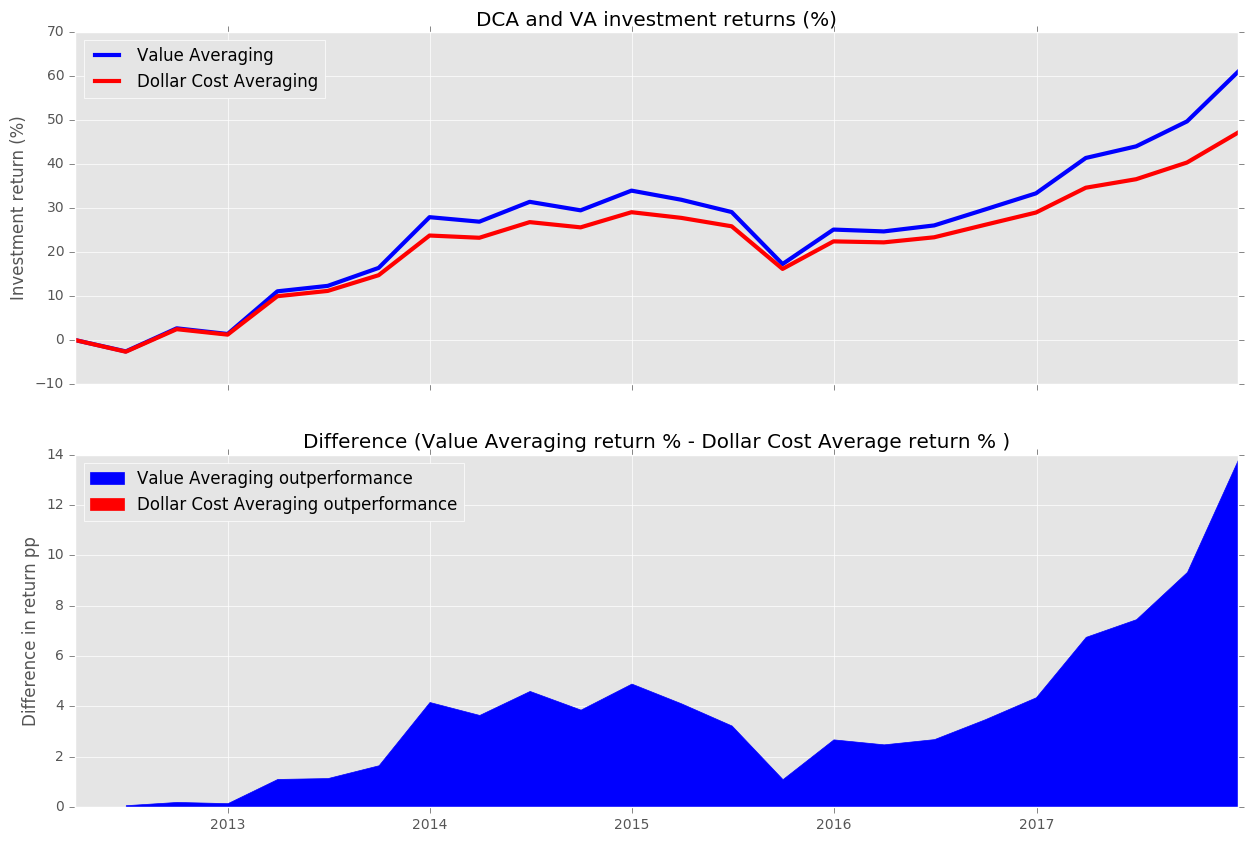

In [44]:
bull_summary = comparison_graphs(bull_dca, bull_va)
bull_summary

In [45]:
def summary_table(df_dca, df_va, xirr_dca, xirr_va, dca_col, va_col):
    summary = [['Final Value', df_dca['DCA_Total_Val'][-1], df_va['VA_Total_Val'][-1]],
          ['Total Invested', -df_dca['DCA_cum_inv'][-1], -df_va['VA_cum_inv'][-1]],
          ['Profit / Loss', df_dca['DCA_P&L'][-1], df_va['VA_P&L'][-1]],
          ['Avg share price', df_dca['DCA_avg_price'][-1], df_va['VA_avg_price'][-1]],
          ['XIRR', xirr_dca*100, xirr_va*100]]

    bull_summary = pd.DataFrame(summary, columns=['Measure', dca_col, va_col])
    bull_summary = bull_summary.set_index('Measure')
    bull_summary['DCA - VA'] = bull_summary[dca_col] - bull_summary[va_col]
    return bull_summary

In [46]:
bull_table = summary_table(bull_dca, bull_va, bull_dca_xirr, bull_va_xirr, 'DCA_bull', 'VA_bull')
bull_table

,DCA_bull,VA_bull,DCA - VA
Measure,,,
Final Value,99303.76,67500.00,31803.76
Total Invested,67500.00,41947.36,25552.64
Profit / Loss,31803.76,25552.64,6251.12
Avg share price,1817.34,1661.49,155.85
XIRR,12.05,12.16,-0.11


### Bull market delivered solid results for both methods.
<br>**Dollar Cost Averaging** saw xirr of **11.0%** while **Value Averaging 11.2%.**

* **DCA's total investment of \$67,500**  (which was known in advance) **returned final value of \~$99,300.**
* **VA's final value of \$67,500** (which was known in advance) was achieved with **total investment of ~\$41,900.**

<br> Although VA's percentage return was slightly higher than DCA's it's the latter that produced above \$6k more profit in nominal value (but required \$~25.6k more capital injection).


# Study 2: Downtrend
As an example of a bear market I will use **Deutsche Bank equity**. The company had it's share of difficulties and financial issues which brought price down. <br>At the beggining of 2012 one share was priced at \$36.31 and at the end of 2017 at \$19.03 which translates into **6 year return of -48%**. Prices doesn't include dividends which were distributed during analize period and would increase total return. However even if accounted for that downtrend would still be clear. 

### Stock performance visualisation 

In [47]:
bear_df = quotes_df('DB.US', start, end)

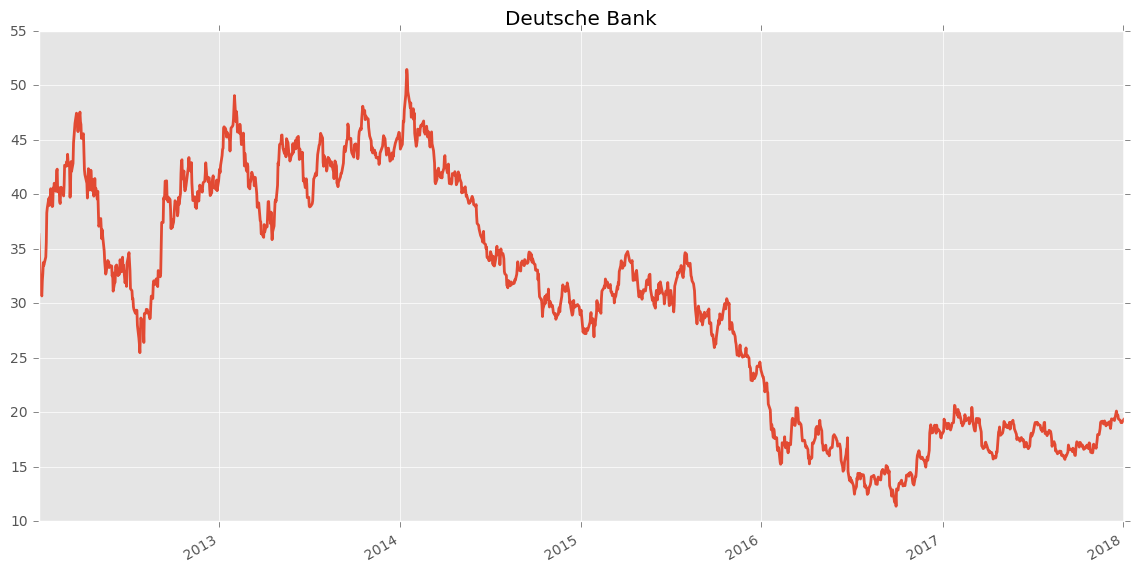

In [48]:
ax = bear_df.plot(figsize=(14,7), linewidth=2, legend=False, title = 'Deutsche Bank')
plt.xlabel('');

### Dollar Cost Averaging DataFrame:

In [49]:
bear_dca, bear_dca_xirr = dca_df_creator(bear_df, guess_val=-0.5)
bear_dca

,Price,DCA_contr,DCA_cum_inv,DCA_shares_bought,DCA_cum_shares,DCA_Total_Val,DCA_avg_price,DCA_P&L
Data,,,,,,,,
2012-03-31,45.39,-10000,-10000,220.30,220.30,10000.00,45.39,0.00
2012-06-30,33.68,-2500,-12500,74.23,294.53,9919.43,42.44,-2580.57
2012-09-30,36.92,-2500,-15000,67.72,362.24,13373.70,41.41,-1626.30
2012-12-31,41.24,-2500,-17500,60.62,422.87,17438.96,41.38,-61.04
2013-03-31,36.42,-2500,-20000,68.63,491.50,17902.86,40.69,-2097.14
2013-06-30,39.70,-2500,-22500,62.97,554.47,22012.03,40.58,-487.97
2013-09-30,43.42,-2500,-25000,57.58,612.05,26573.56,40.85,1573.56
2013-12-31,45.65,-2500,-27500,54.76,666.82,30440.89,41.24,2940.89
2014-03-31,42.42,-2500,-30000,58.93,725.75,30789.07,41.34,789.07


### Value Averaging DataFrame

In [50]:
bear_va, bear_va_xirr = va_df_creator(bear_df, guess_val=-0.5)
bear_va

,Price,VA_contr,VA_cum_inv,VA_shares_bought,VA_cum_shares,VA_Total_Val,VA_avg_price,VA_P&L
Data,,,,,,,,
2012-03-31,45.39,-10000.00,-10000.00,220.30,220.30,10000.00,45.39,0.00
2012-06-30,33.68,-5080.57,-15080.57,150.85,371.15,12500.00,40.63,-2580.57
2012-09-30,36.92,-1297.47,-16378.04,35.14,406.29,15000.00,40.31,-1378.04
2012-12-31,41.24,-744.40,-17122.44,18.05,424.35,17500.00,40.35,377.56
2013-03-31,36.42,-4543.22,-21665.67,124.73,549.07,20000.00,39.46,-1665.67
2013-06-30,39.70,-702.33,-22368.00,17.69,566.76,22500.00,39.47,132.00
2013-09-30,43.42,-392.77,-22760.77,9.05,575.81,25000.00,39.53,2239.23
2013-12-31,45.65,-1213.64,-23974.41,26.59,602.40,27500.00,39.80,3525.59
2014-03-31,42.42,-4443.93,-28418.34,104.75,707.15,30000.00,40.19,1581.66


### Bear market results comparison

,DCA_cum_inv,DCA_P&L,VA_cum_inv,VA_P&L,DCA_return,VA_return,diff
Data,,,,,,,
2016-12-31,-57500,-21991.88,-79811.22,-22311.22,-38.25,-27.95,10.29
2017-03-31,-60000,-23836.20,-85297.82,-25297.82,-39.73,-29.66,10.07
2017-06-30,-62500,-22099.91,-84917.11,-22417.11,-35.36,-26.40,8.96
2017-09-30,-65000,-23258.09,-89208.85,-24208.85,-35.78,-27.14,8.64
2017-12-31,-67500,-19030.75,-85126.09,-17626.09,-28.19,-20.71,7.49


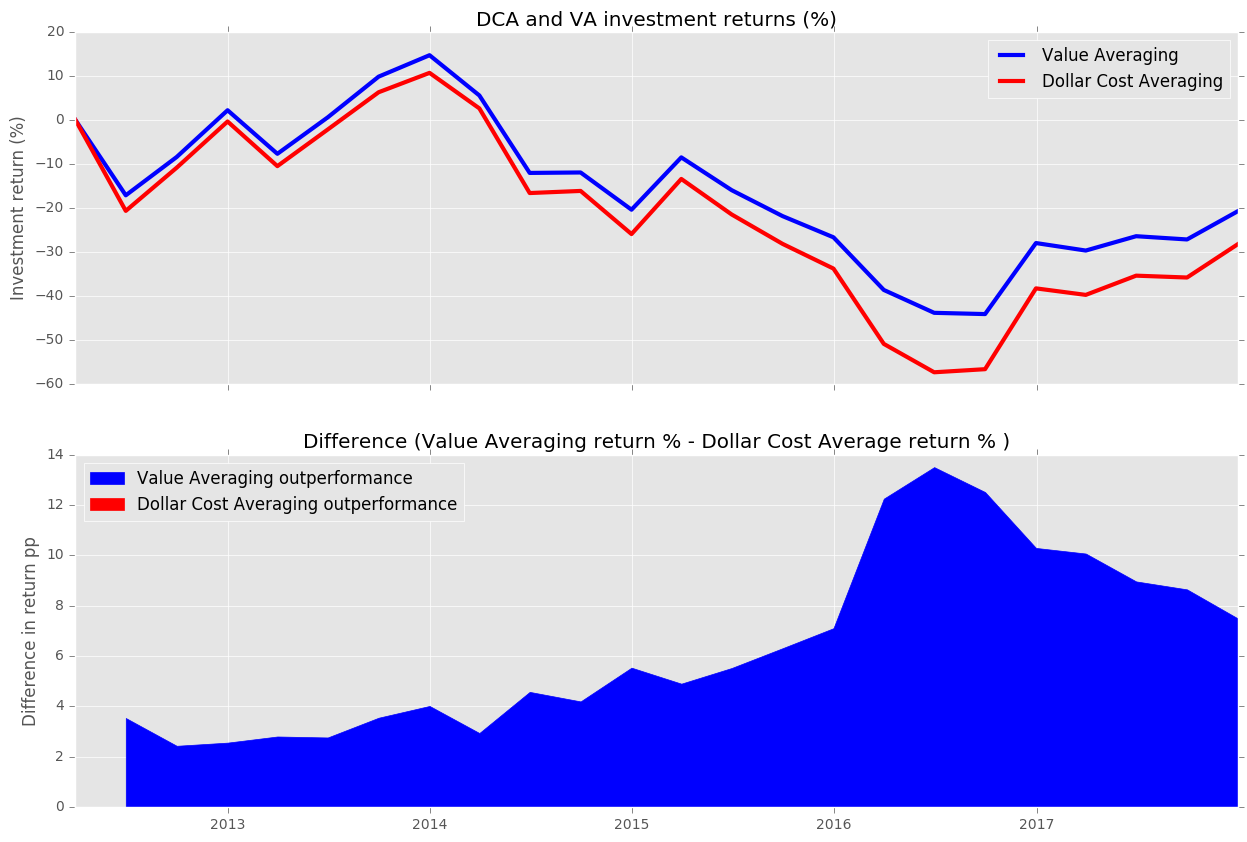

In [51]:
comparison_graphs(bear_dca, bear_va)

In [52]:
bear_table = summary_table(bear_dca, bear_va, bear_dca_xirr, bear_va_xirr, 'DCA_bear', 'VA_bear')
bear_table

,DCA_bear,VA_bear,DCA - VA
Measure,,,
Final Value,48469.25,67500.00,-19030.75
Total Invested,67500.00,85126.09,-17626.09
Profit / Loss,-19030.75,-17626.09,-1404.66
Avg share price,26.50,24.00,2.50
XIRR,-10.43,-6.87,-3.57


### As expected bear market brought losses and negative returns for both methods.
<br>**Dollar Cost Averaging** saw xirr of **-10.4%** while **Value Averaging -6.9%**

* **DCA's total investment of \$67,500**  (which was known in advance) ended up with **loss of \~$29,000.**
* **VA's final value of \$67,500** (which was known in advance) was achieved with total investment of ~\$85,100 and **delivered ~\$17,600 loss**

<br> Value Averaging was more successful method in this example as it's annualized return was significantly higher due to lower average share price bought. This is related to more aggresive buying when prices are the lowest. However VA has material limitation as it is unknown in advance how much capital will be needed to inject and investor may face the risk of running out of money to invest in trending down asset. Also in the worst case scenario when asset price will be worth nothing or close to nothing (e.g in case of bankrupcy or huge shares issuance which would dilute capital) than VA will become a losing stategy  with significantly higher capital loss.


# Study 3: Horizontal trend
As an example of horizontal trend I will use **Randgold Resources** a gold mining company. <br>
As visible in the plot below it's hard to point out the prevailing bull or bear market in analyse period as upward movements were followed by price falls. First trading season in 2012 ended with a price of \$103.64 while last trading day in 2017 closed with a price of \$98.79 which means a **6 year return of -5%**.

### Stock performance visualisation

In [53]:
consol_df = quotes_df('GOLD.US', start, end)

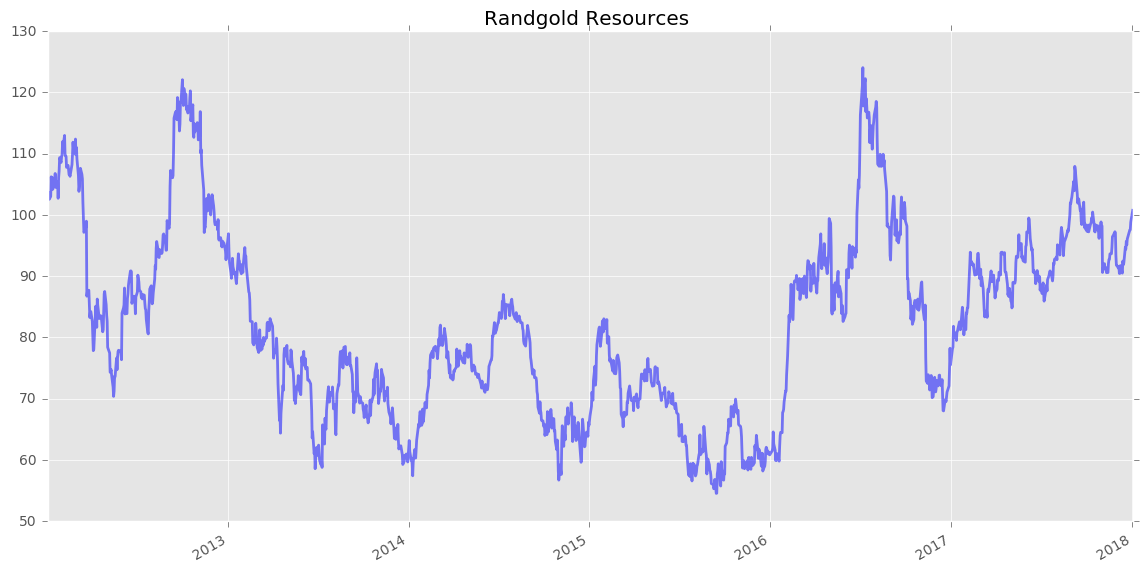

In [54]:
ax = consol_df.plot(figsize=(14,7), linewidth=2, legend=False, title = 'Randgold Resources ', color='b', alpha=0.5)
plt.xlabel('');

### Dollar Cost Averaging DataFrame:

In [55]:
consol_dca, consol_dca_xirr = dca_df_creator(consol_df, guess_val=-0.5)
consol_dca

,Price,DCA_contr,DCA_cum_inv,DCA_shares_bought,DCA_cum_shares,DCA_Total_Val,DCA_avg_price,DCA_P&L
Data,,,,,,,,
2012-03-31,84.20,-10000,-10000,118.77,118.77,10000.00,84.20,0.00
2012-06-30,86.59,-2500,-12500,28.87,147.64,12783.61,84.67,283.61
2012-09-30,118.32,-2500,-15000,21.13,168.77,19968.64,88.88,4968.64
2012-12-31,95.44,-2500,-17500,26.20,194.96,18606.89,89.76,1106.89
2013-03-31,82.71,-2500,-20000,30.23,225.19,18625.20,88.81,-1374.80
2013-06-30,61.95,-2500,-22500,40.36,265.55,16449.82,84.73,-6050.18
2013-09-30,69.24,-2500,-25000,36.11,301.66,20885.39,82.88,-4114.61
2013-12-31,60.80,-2500,-27500,41.12,342.78,20839.12,80.23,-6660.88
2014-03-31,73.02,-2500,-30000,34.24,377.01,27530.94,79.57,-2469.06


### Value Averaging DataFrame

In [56]:
consol_va, consol_va_xirr = va_df_creator(consol_df, guess_val=-0.5)
consol_va

,Price,VA_contr,VA_cum_inv,VA_shares_bought,VA_cum_shares,VA_Total_Val,VA_avg_price,VA_P&L
Data,,,,,,,,
2012-03-31,84.20,-10000.00,-10000.00,118.77,118.77,10000.00,84.20,0.00
2012-06-30,86.59,-2216.39,-12216.39,25.60,144.36,12500.00,84.62,283.61
2012-09-30,118.32,2081.09,-10135.30,-17.59,126.77,15000.00,79.95,4864.70
2012-12-31,95.44,-5400.86,-15536.16,56.59,183.37,17500.00,84.73,1963.84
2013-03-31,82.71,-4834.05,-20370.22,58.45,241.81,20000.00,84.24,-370.22
2013-06-30,61.95,-7520.49,-27890.71,121.40,363.21,22500.00,76.79,-5390.71
2013-09-30,69.24,147.46,-27743.25,-2.13,361.08,25000.00,76.83,-2743.25
2013-12-31,60.80,-5547.91,-33291.15,91.26,452.34,27500.00,73.60,-5791.15
2014-03-31,73.02,3031.66,-30259.49,-41.52,410.82,30000.00,73.66,-259.49


### Consolidation market results comparison

,DCA_cum_inv,DCA_P&L,VA_cum_inv,VA_P&L,DCA_return,VA_return,diff
Data,,,,,,,
2016-12-31,-57500,-789.05,-47665.22,9834.78,-1.37,20.63,22.01
2017-03-31,-60000,8066.31,-41186.65,18813.35,13.44,45.68,32.23
2017-06-30,-62500,8986.55,-42875.47,19624.53,14.38,45.77,31.39
2017-09-30,-65000,16421.28,-38875.36,26124.64,25.26,67.20,41.94
2017-12-31,-67500,17363.39,-40623.26,26876.74,25.72,66.16,40.44


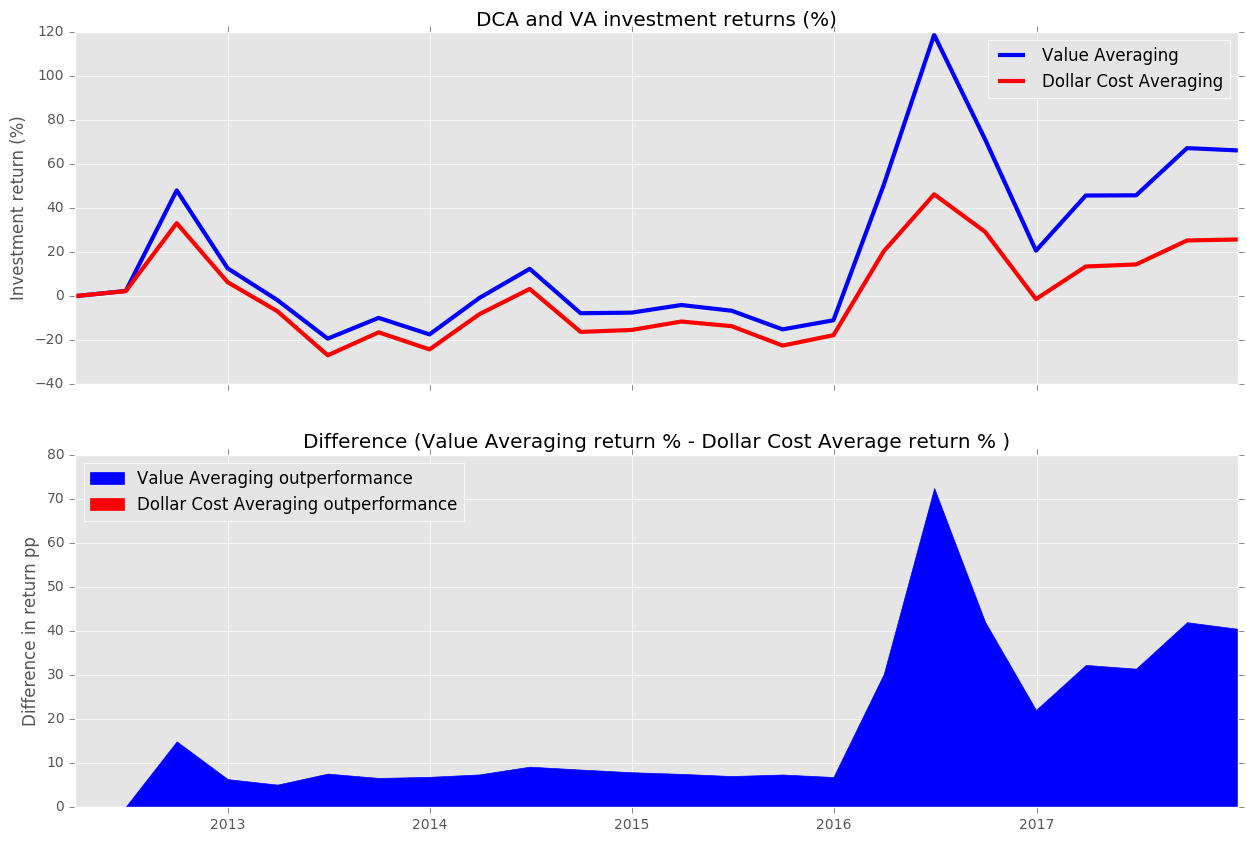

In [57]:
comparison_graphs(consol_dca, consol_va)

In [58]:
horizontal_table = summary_table(consol_dca, consol_va, consol_dca_xirr, consol_va_xirr, 'DCA_horiz', 'VA_horiz')
horizontal_table

,DCA_horiz,VA_horiz,DCA - VA
Measure,,,
Final Value,84863.39,67500.00,17363.39
Total Invested,67500.00,40623.26,26876.74
Profit / Loss,17363.39,26876.74,-9513.36
Avg share price,78.58,59.45,19.12
XIRR,7.14,11.52,-4.38


### Horizontal trend delivered positive results for both methods.
<br>**Dollar Cost Averaging** saw xirr of **7.1%** while **Value Averaging 11.5%**

* **DCA's total investment of \$67,500**  (which was known in advance) ended up with **total value of \~$84,900.**
* **VA's final value of \$67,500** (which was known in advance) was achieved with total investment of just **~\$40,600**

<br> Value Averaging was a clear winner in the above case. It acheived 55% higher annualized return, ~\$9,500 higher profit and required ~\$26,900 less capital. Since assets value are mean reversing it is greatly beneficial to buy more subdued stocks and bring down average buy price which VA is all about.

# Three scenarios summary

In [59]:
final_summary = pd.concat([bull_table.iloc[:,:2], bear_table.iloc[:,:2], horizontal_table.iloc[:,:2]], axis=1)
final_summary

,DCA_bull,VA_bull,DCA_bear,VA_bear,DCA_horiz,VA_horiz
Measure,,,,,,
Final Value,99303.76,67500.00,48469.25,67500.00,84863.39,67500.00
Total Invested,67500.00,41947.36,67500.00,85126.09,67500.00,40623.26
Profit / Loss,31803.76,25552.64,-19030.75,-17626.09,17363.39,26876.74
Avg share price,1817.34,1661.49,26.50,24.00,78.58,59.45
XIRR,12.05,12.16,-10.43,-6.87,7.14,11.52


### Dollar Cost Averaging conclusions:
* **Less risky** as the worst case scenario (loss of all invested capital) is not uncertain as contributions are know in advance
* **Lower annualized returns** as relatively lower amount of shares is bought during the periods of depressed prices
* **Uncertain final value of investment**
* Can produce **higher profits in bull market** as more capital is invested

### Value Averaging conclusions:
* **More risky** as the worst case scenario (loss of all invested capital) is uncertain due to unknow contributions during investment period
* **Higher annualized returns** as more shares are bought during the period of depressed prices leading to lower average buy price of an asset
* **Final value of investment is known** (assuming asset value will not fall to 0)
* Can produce **higher profits in horizontal market** as more shares are bought in the times of weakness in the anticipation of mean reversion